# Importing Liraries

In [34]:
import os
import json
from pathlib import Path
import tifffile as tiff
import rasterio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from PIL import Image, ImageDraw
import cv2

from ultralytics import YOLO
import yaml

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import random
from tqdm import tqdm
import shutil
import glob
from typing import List

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# File Locations

In [4]:
GEOJSON = '01_training_dataset_geojson_nuclei/'
TIFF_FOLDER = '01_training_dataset_tif_ROIs/'
MASKS = 'masks/'

# Creating Mask TIFF Files For Each GeoJSON

In [5]:
def create_mask_pil(geojson_file, output_path, image_size=(1024, 1024)):
    with open(geojson_file, "r") as f:
        data = json.load(f)

    mask = Image.new("RGBA", image_size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(mask)

    for feature in data.get("features", []):
        geometry = feature.get("geometry", {})
        properties = feature.get("properties", {})

        if geometry.get("type") == "Polygon":
            for polygon_coordinates in geometry.get("coordinates", []):
                coords = np.array(polygon_coordinates, dtype=np.int32)

                coords = [tuple(map(int, point)) for point in coords]

                classification = properties.get("classification", {})
                color_rgb = tuple(classification.get("color", [0, 0, 0]))  

                draw.polygon(coords, fill=color_rgb, outline=color_rgb)

    mask_np = np.array(mask)
    tiff.imwrite(output_path, mask_np)

def process_geojson_files(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for geojson_file in tqdm(os.listdir(input_dir)):
        if geojson_file.endswith(".geojson"):
            input_path = os.path.join(input_dir, geojson_file)
            filename = Path(geojson_file).stem.replace("_nuclei", "") + ".tif"
            output_path = os.path.join(output_dir, filename)

            create_mask_pil(input_path, output_path)
    print("Process Finished Successfully")

In [6]:
process_geojson_files('01_training_dataset_geojson_nuclei/', 'masks/')

100%|██████████| 205/205 [00:12<00:00, 15.80it/s]

Process Finished Successfully


# TIFF and Masks

In [7]:
def load_and_display_samples(tif_folder, mask_folder, num_samples=3):
    tif_files = sorted([f for f in os.listdir(tif_folder) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png') or f.endswith('.tif')])

    matching_files = list(set(tif_files) & set(mask_files))
    if len(matching_files) == 0:
        print("No matching TIFF and mask files found.")
        return

    num_samples = min(num_samples, len(matching_files))
    selected_files = random.sample(matching_files, num_samples)

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 5 * num_samples))

    for idx, filename in enumerate(selected_files):
        tif_path = os.path.join(tif_folder, filename)
        with rasterio.open(tif_path) as src:
            tif_image = src.read(1)  

        mask_path = os.path.join(mask_folder, filename)
        mask_image = np.array(Image.open(mask_path))

        if num_samples > 1:
            ax_tif, ax_mask = axes[idx]
        else:
            ax_tif, ax_mask = axes

        ax_tif.imshow(tif_image, cmap="gray")
        ax_tif.set_title(f"TIFF: {filename}")
        ax_tif.axis("off")

        ax_mask.imshow(mask_image, cmap="jet", alpha=0.6)
        ax_mask.set_title(f"Mask: {filename}")
        ax_mask.axis("off")

    plt.tight_layout()
    plt.show()

/home/tamim-ishrak/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


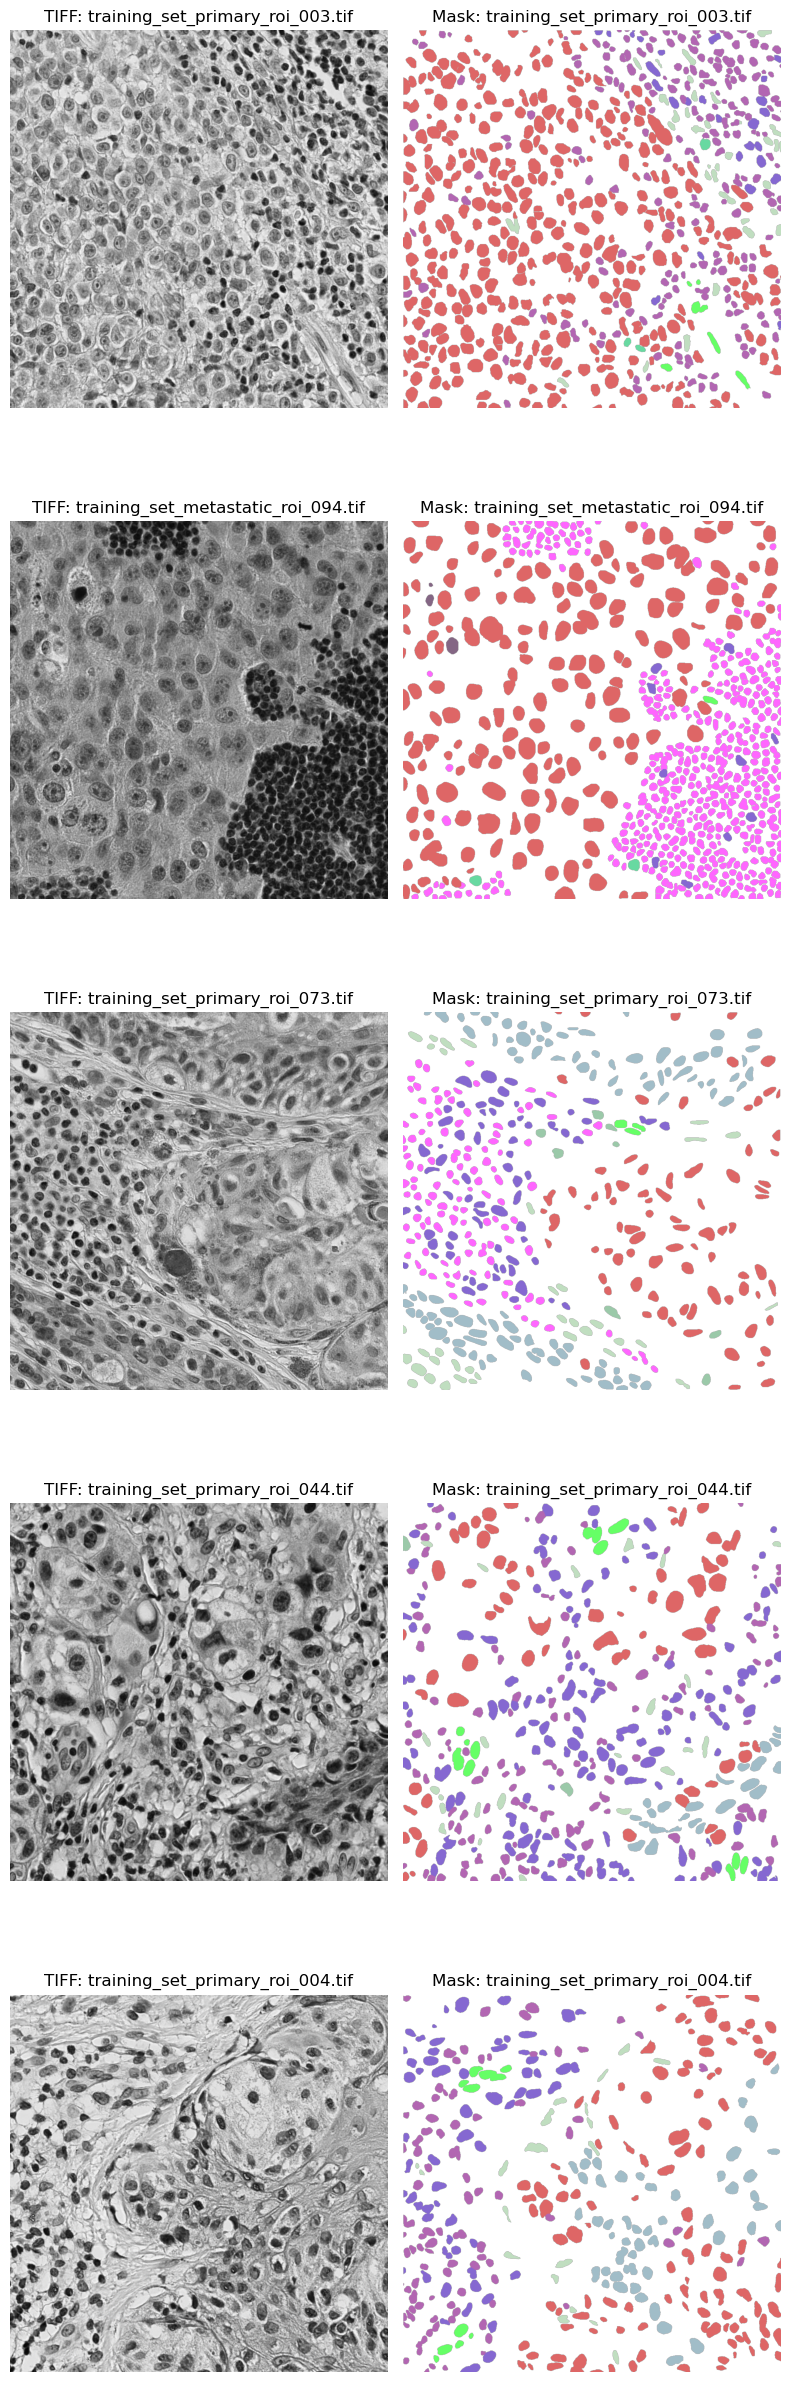

In [8]:
load_and_display_samples(TIFF_FOLDER, MASKS, num_samples=5)

# Data Augmentation and Saving The Augmented Data

In [9]:
augmentation = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])

In [10]:
input_image_dir = TIFF_FOLDER
input_mask_dir = MASKS
output_image_dir = "augment/images"
output_mask_dir = "augment/masks"

In [11]:
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

In [12]:
image_files = sorted([f for f in os.listdir(input_image_dir) if f.endswith(".tif")])
mask_files = sorted([f for f in os.listdir(input_mask_dir) if f.endswith(".tif")])

In [13]:
for img_name, mask_name in tqdm(zip(image_files, mask_files)):
    img_path = os.path.join(input_image_dir, img_name)
    mask_path = os.path.join(input_mask_dir, mask_name)

    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)

    for i in range(20):
        seed = torch.randint(0, 10000, (1,)).item()  
        torch.manual_seed(seed)
        img_transformed = augmentation(img)

        torch.manual_seed(seed)
        mask_transformed = augmentation(mask)

        img_transformed = transforms.ToPILImage()(img_transformed)
        mask_transformed = transforms.ToPILImage()(mask_transformed)

        img_save_path = os.path.join(output_image_dir, f"{img_name.split('.')[0]}_aug_{i}.tif")
        mask_save_path = os.path.join(output_mask_dir, f"{mask_name.split('.')[0]}_aug_{i}.tif")

        img_transformed.save(img_save_path)
        mask_transformed.save(mask_save_path)

print("Augmentation process completed!")

205it [01:43,  1.98it/s]

Augmentation process completed!


In [14]:
AUGMENTED_IMAGES = 'augment/images/'
AUGMENTED_MASKS = 'augment/masks/'

# Creating a Class Info and Color Map

In [15]:
class_info = {
    0: {"name": "nuclei_tumor", "color_rgb": (200, 0, 0)},
    1: {"name": "nuclei_lymphocyte", "color_rgb": (255, 0, 255)},
    2: {"name": "nuclei_plasma_cell", "color_rgb": (3, 193, 98)},
    3: {"name": "nuclei_endothelium", "color_rgb": (0, 255, 0)},
    4: {"name": "nuclei_stroma", "color_rgb": (150, 200, 150)},
    5: {"name": "nuclei_apoptosis", "color_rgb": (51, 0, 51)},
    6: {"name": "nuclei_lymphocyte", "color_rgb": (128, 0, 128)},
    7: {"name": "nuclei_histiocyte", "color_rgb": (52, 4, 179)},
    8: {"name": "nuclei_melanophage", "color_rgb": (89, 165, 113)},
    9: {"name": "nuclei_apoptosis", "color_rgb": (0, 0, 0)},
    10: {"name": "nuclei_epithelium", "color_rgb": (99, 145, 164)},
    11: {"name": "nuclei_neutrophil", "color_rgb": (51, 51, 51)},
    12: {"name": "nuclei_neutrophil", "color_rgb": (0, 255, 255)},
    13: {"name": "nuclei_lymphocyte", "color_rgb": (51, 81, 147)},
    14: {"name": "nuclei_epithelium", "color_rgb": (0, 128, 128)},
    15: {"name": "nuclei_endothelium", "color_rgb": (0, 128, 0)},
    16: {"name": "nuclei_tumor", "color_rgb": (255, 0, 0)},
    17: {"name": "nuclei_stroma", "color_rgb": (51, 102, 51)},
    18: {"name": "nuclei_histiocyte", "color_rgb": (204, 204, 51)},
    19: {"name": "nuclei_melanophage", "color_rgb": (102, 26, 51)},
    20: {"name": "nuclei_histiocyte", "color_rgb": (51, 81, 147)},
    21: {"name": "nuclei_plasma_cell", "color_rgb": (0, 0, 128)},
    22: {"name": "nuclei_neutrophil", "color_rgb": (36, 157, 192)},
    23: {"name": "nuclei_endothelium", "color_rgb": (159, 99, 69)},
}

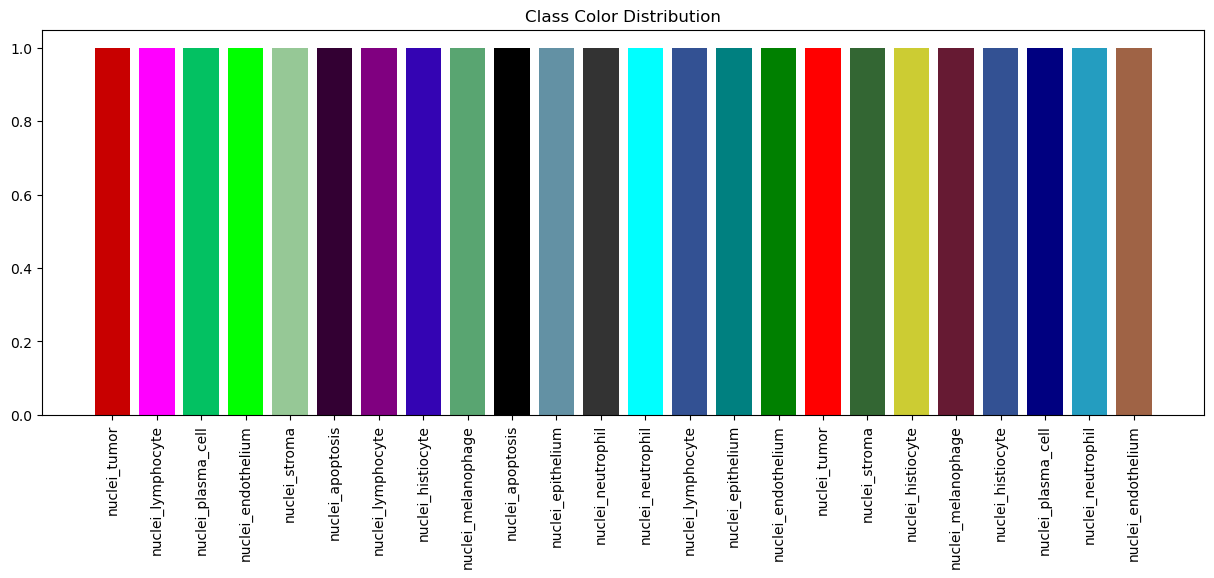

In [16]:
plt.figure(figsize=(15, 5))
for i, (class_id, info) in enumerate(class_info.items()):
    plt.bar(i, 1, color=np.array(info["color_rgb"])/255)
plt.title("Class Color Distribution")
plt.xticks(range(len(class_info)), [info["name"] for info in class_info.values()], rotation=90)
plt.show()

# Processing Files in YOLO Format

In [17]:
def create_yolo_annotation(mask, output_path, class_info, min_area=10):
    if len(mask.shape) == 2:
        raise ValueError("Mask must be an RGB image.")
    elif mask.shape[-1] == 4:
        mask = mask[:, :, :3] 

    contours_dict = {class_id: [] for class_id in class_info}
    
    for class_id, info in class_info.items():
        target_color = np.array(info["color_rgb"])

        color_diff = np.sum(np.abs(mask.astype(int) - target_color), axis=-1)
        binary_mask = (color_diff < 50).astype(np.uint8) * 255  # Thresholding

        if np.max(binary_mask) == 0:
            continue  

        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            if cv2.contourArea(contour) < min_area:
                continue  

            epsilon = 0.002 * cv2.arcLength(contour, True) 
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            if len(approx) < 3:
                continue  
            
            contours_dict[class_id].append(approx)

    with open(output_path, 'w') as f:
        for class_id, contours in contours_dict.items():
            for contour in contours:
                points = contour.reshape(-1, 2)
                h, w = mask.shape[:2]

                points_normalized = points.astype(float)
                points_normalized[:, 0] /= w
                points_normalized[:, 1] /= h

                line = f"{class_id} " + " ".join([f"{x:.6f} {y:.6f}" for x, y in points_normalized])
                f.write(line + "\n")

In [18]:
def convert_to_yolo_format(image_dir, mask_dir, output_dir, class_info, split_ratio=0.8):
    os.makedirs(os.path.join(output_dir, "images", "train"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images", "val"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "labels", "train"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "labels", "val"), exist_ok=True)

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])
    
    matching_files = [f for f in image_files if f in mask_files]
    
    if not matching_files:
        print("No matching image-mask pairs found!")
        return

    random.shuffle(matching_files)
    split_idx = int(len(matching_files) * split_ratio)
    train_files, val_files = matching_files[:split_idx], matching_files[split_idx:]

    print("Processing training files...")
    for filename in tqdm(train_files):
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)
        
        try:
            img = Image.open(img_path)
            png_filename = filename.replace('.tif', '.png')
            img.save(os.path.join(output_dir, "images", "train", png_filename))

            mask = np.array(Image.open(mask_path))
            label_path = os.path.join(output_dir, "labels", "train", png_filename.replace('.png', '.txt'))
            create_yolo_annotation(mask, label_path, class_info)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

    print("Processing validation files...")
    for filename in tqdm(val_files):
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)
        
        try:
            img = Image.open(img_path)
            png_filename = filename.replace('.tif', '.png')
            img.save(os.path.join(output_dir, "images", "val", png_filename))

            mask = np.array(Image.open(mask_path))
            label_path = os.path.join(output_dir, "labels", "val", png_filename.replace('.png', '.txt'))
            create_yolo_annotation(mask, label_path, class_info)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

    create_yaml(output_dir, [info["name"] for _, info in sorted(class_info.items())])

    print(f"YOLO format dataset created successfully!")
    print(f"Train: {len(train_files)} images")
    print(f"Validation: {len(val_files)} images")

In [19]:
def create_yaml(output_dir, class_names):
    yaml_path = os.path.join(output_dir, "dataset.yaml")
    with open(yaml_path, 'w') as f:
        f.write(f"path: {os.path.abspath(output_dir)}\n")
        f.write("train: images/train\n")
        f.write("val: images/val\n")
        f.write("test: \n")  
        f.write(f"nc: {len(class_names)}\n")
        f.write(f"names: {class_names}\n")

In [20]:
convert_to_yolo_format(
    AUGMENTED_IMAGES,
    AUGMENTED_MASKS,
    "yolo_dataset",
    class_info
)

Processing training files...


100%|██████████| 3280/3280 [03:30<00:00, 15.59it/s]


Processing validation files...


100%|██████████| 820/820 [00:52<00:00, 15.52it/s]

YOLO format dataset created successfully!
Train: 3280 images
Validation: 820 images


# Calculating the Class Weights based on Label Distribution

In [21]:
def calculate_class_weights(yolo_dataset_dir):
    label_dir = os.path.join(yolo_dataset_dir, "labels", "train")
    class_counts = {}
    
    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue
            
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1
                
    total = sum(class_counts.values())
    weights = {k: total/(v * len(class_counts)) for k, v in class_counts.items()}
    
    return weights

In [22]:
class_weights = calculate_class_weights("yolo_dataset")
print("Class weights:", class_weights)

Class weights: {0: 0.08312102175575659, 1: 0.9763176693081722, 2: 6.204773335946175, 3: 2.5283844392983577, 4: 1.3112041714979847, 7: 0.5016788404051927, 9: 0.4422509719021347, 5: 0.6416259693064225, 6: 0.39043316439983394, 8: 4.186007183148246, 11: 6.431638905816237, 15: 5.960647276606426, 17: 17.949522864701436, 10: 3.1262794562927856, 13: 439.76331018518516, 20: 439.76331018518516, 12: 34.15637360661633, 14: 10.135389991463935, 16: 6.756926660975957, 18: 39.77758584589615, 19: 275.3300724637681, 21: 282.7049851190476, 23: 1759.0532407407406, 22: 2435.6121794871797}


# Training YOLO for Panoptic Segmentation

In [48]:
def train_yolo_model(yolo_dataset_dir, device="cpu"):
    """Optimized YOLO training for panoptic segmentation on CPU."""
    print(f"Using device: {device} (Training on CPU will be slow)")

    print("Initializing YOLO model...")
    model = YOLO('yolov8n-seg.pt')  

    print("Starting training...")
    results = model.train(
        data=os.path.join(yolo_dataset_dir, "dataset.yaml"),
        epochs=30,          # Reduced from 40 for faster convergence
        imgsz=256,          # Lower resolution to save RAM
        batch=2,            # Reduced to fit in 8GB RAM
        device=device,
        project="melanoma_segmentation",
        name="yolo8n_model_cpu_optimized",
        cache=False,        # Avoid excessive RAM usage
        amp=False,          # AMP is GPU-specific, disable it
        optimizer='Adam',   # Adam is more stable on CPUs
        lr0=0.0005,         # Slightly lower learning rate
        momentum=0.9,
        weight_decay=0.0001,
        warmup_epochs=1,    # Faster warmup

        # **Panoptic-Specific Parameters**
        overlap_mask=True,  # Ensures masks don't overlap too much
        mask_ratio=3,       # Lower mask complexity to save memory
        single_cls=False,   # If multiple nuclei types, keep False

        # **Reduced Augmentation (to avoid memory spikes)**
        mosaic=0.0,         # Mosaic augmentation is not useful for segmentation
        fliplr=0.2,         # Small probability for horizontal flip
        copy_paste=0.0,     # Not useful for panoptic segmentation
        mixup=0.0           # Mixup is unnecessary for segmentation
    )    
    
    return results


In [24]:
results = train_yolo_model("yolo_dataset", device)

Using device: cpu (Training on CPU will be slow)
Initializing YOLO model...


100%|██████████| 6.74M/6.74M [00:02<00:00, 3.15MB/s]


Starting training...
New https://pypi.org/project/ultralytics/8.3.96 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.95 🚀 Python-3.12.3 torch-2.5.1+cu124 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=yolo_dataset/dataset.yaml, epochs=30, time=None, patience=100, batch=2, imgsz=256, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=melanoma_segmentation, name=yolo11n_model_cpu_optimized, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=3, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nm

train: Scanning /home/tamim-ishrak/Documents/malenoma/yolo_dataset/labels/train... 3280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3280/3280 [00:19<00:00, 172.25it/s]


train: New cache created: /home/tamim-ishrak/Documents/malenoma/yolo_dataset/labels/train.cache


val: Scanning /home/tamim-ishrak/Documents/malenoma/yolo_dataset/labels/val... 820 images, 0 backgrounds, 0 corrupt: 100%|██████████| 820/820 [00:04<00:00, 167.80it/s]


val: New cache created: /home/tamim-ishrak/Documents/malenoma/yolo_dataset/labels/val.cache
Plotting labels to melanoma_segmentation/yolo11n_model_cpu_optimized/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0001), 76 bias(decay=0.0)


2025/03/26 03:34:30 INFO mlflow.tracking.fluent: Experiment with name 'melanoma_segmentation' does not exist. Creating a new experiment.
2025/03/26 03:34:30 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.11.1 <= statsmodels <= 0.14.3, but the installed version is 0.14.4. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/03/26 03:34:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/26 03:34:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/03/26 03:34:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/26 03:34:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(e48036476dc14a18a0ce8fa7910bfb28) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to melanoma_segmentation/yolo11n_model_cpu_optimized
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      2.809      4.477      2.198      1.161        315        256: 100%|██████████| 1640/1640 [12:03<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [04:22<00:00,  1.28s/it]


                   all        820     191865      0.151     0.0175     0.0212    0.00955      0.141     0.0071     0.0077    0.00249

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      2.665      4.236      1.995      1.112        431        256: 100%|██████████| 1640/1640 [11:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [03:55<00:00,  1.15s/it]


                   all        820     191865     0.0289     0.0318     0.0258     0.0115     0.0118     0.0137    0.00898     0.0025

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      2.598      4.033       1.92      1.097        458        256: 100%|██████████| 1640/1640 [11:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [03:36<00:00,  1.05s/it]


                   all        820     191865     0.0323     0.0375     0.0287     0.0126      0.012     0.0149    0.00948    0.00266

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G       2.57      3.873      1.883      1.089        312        256: 100%|██████████| 1640/1640 [11:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [03:18<00:00,  1.03it/s]


                   all        820     191865     0.0716     0.0391     0.0504     0.0225     0.0227     0.0141     0.0148    0.00458

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      2.542      3.789      1.846      1.084        353        256: 100%|██████████| 1640/1640 [11:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [03:12<00:00,  1.06it/s]


                   all        820     191865     0.0701     0.0384     0.0494     0.0188     0.0285      0.014     0.0177    0.00467

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      2.512      3.732      1.819      1.077        309        256: 100%|██████████| 1640/1640 [11:12<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [03:07<00:00,  1.09it/s]


                   all        820     191865     0.0624     0.0396     0.0462     0.0181     0.0154     0.0132      0.011    0.00333

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      2.487      3.687      1.801      1.076        502        256: 100%|██████████| 1640/1640 [11:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:50<00:00,  1.20it/s]


                   all        820     191865     0.0787     0.0401     0.0554     0.0258     0.0369     0.0148     0.0221    0.00556

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      2.475      3.653      1.784      1.071        416        256: 100%|██████████| 1640/1640 [11:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:55<00:00,  1.17it/s]


                   all        820     191865     0.0841     0.0437     0.0587     0.0302     0.0453      0.017     0.0267    0.00889

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      2.462      3.623      1.768      1.068        373        256: 100%|██████████| 1640/1640 [11:09<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:42<00:00,  1.26it/s]


                   all        820     191865     0.0736     0.0432     0.0534     0.0267     0.0247      0.015     0.0159    0.00403

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      2.439      3.605      1.751      1.065        355        256: 100%|██████████| 1640/1640 [11:12<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:46<00:00,  1.23it/s]


                   all        820     191865     0.0862      0.044       0.06       0.03      0.037     0.0164     0.0225    0.00607

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      2.438      3.589      1.746      1.065        457        256: 100%|██████████| 1640/1640 [11:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:38<00:00,  1.29it/s]


                   all        820     191865     0.0827     0.0433     0.0583     0.0275     0.0266     0.0157     0.0172    0.00515

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      2.432      3.582      1.737      1.059        319        256: 100%|██████████| 1640/1640 [11:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:41<00:00,  1.27it/s]


                   all        820     191865      0.091     0.0456     0.0634     0.0286       0.03     0.0168      0.019    0.00519

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      2.411       3.55       1.72       1.06        417        256: 100%|██████████| 1640/1640 [11:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:32<00:00,  1.34it/s]


                   all        820     191865      0.073     0.0473     0.0539     0.0252     0.0214     0.0154     0.0144    0.00385

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      2.406      3.541      1.714      1.057        389        256: 100%|██████████| 1640/1640 [11:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:31<00:00,  1.35it/s]


                   all        820     191865     0.0862     0.0438     0.0604       0.03     0.0287     0.0154     0.0181     0.0047

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      2.403       3.54      1.707      1.055        281        256: 100%|██████████| 1640/1640 [11:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:32<00:00,  1.34it/s]


                   all        820     191865     0.0705     0.0485      0.054     0.0252     0.0242     0.0161      0.016    0.00419

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      2.396      3.533      1.696      1.055        366        256: 100%|██████████| 1640/1640 [11:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:33<00:00,  1.33it/s]


                   all        820     191865      0.073     0.0521     0.0559     0.0257     0.0248     0.0164     0.0161      0.004

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      2.394      3.517      1.691      1.055        494        256: 100%|██████████| 1640/1640 [11:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:37<00:00,  1.30it/s]


                   all        820     191865     0.0836     0.0535     0.0608     0.0285     0.0276     0.0178     0.0178     0.0046

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G       2.38      3.497      1.682      1.054        308        256: 100%|██████████| 1640/1640 [11:03<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:28<00:00,  1.38it/s]


                   all        820     191865     0.0791     0.0521     0.0598     0.0279     0.0263     0.0176     0.0174    0.00455

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      2.372       3.49      1.683      1.051        316        256: 100%|██████████| 1640/1640 [11:01<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:33<00:00,  1.33it/s]


                   all        820     191865     0.0742     0.0566     0.0572     0.0264      0.025     0.0188     0.0166    0.00438

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      2.364      3.471      1.672       1.05        324        256: 100%|██████████| 1640/1640 [11:02<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:25<00:00,  1.41it/s]


                   all        820     191865     0.0771     0.0536     0.0584     0.0273     0.0246     0.0186     0.0166    0.00434
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G      2.355      3.467       1.66      1.048        513        256: 100%|██████████| 1640/1640 [11:00<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:27<00:00,  1.39it/s]


                   all        820     191865     0.0755     0.0579     0.0588     0.0272     0.0247     0.0194     0.0168    0.00445

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      2.357      3.462      1.656      1.049        270        256: 100%|██████████| 1640/1640 [11:01<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:31<00:00,  1.36it/s]


                   all        820     191865      0.084     0.0567     0.0631     0.0293     0.0265      0.018     0.0171    0.00453

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      2.354      3.454      1.647      1.045        447        256: 100%|██████████| 1640/1640 [10:58<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:23<00:00,  1.43it/s]


                   all        820     191865     0.0829     0.0564     0.0625     0.0292     0.0268      0.019     0.0178    0.00452

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      2.343      3.441      1.648      1.046        155        256: 100%|██████████| 1640/1640 [11:00<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:22<00:00,  1.44it/s]


                   all        820     191865     0.0796     0.0552     0.0603     0.0275     0.0254     0.0188     0.0172     0.0045

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      2.346      3.435      1.636      1.044        393        256: 100%|██████████| 1640/1640 [11:01<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:19<00:00,  1.47it/s]


                   all        820     191865     0.0802     0.0562     0.0613     0.0283      0.024     0.0183     0.0164    0.00407

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      2.332      3.423      1.634      1.043        351        256: 100%|██████████| 1640/1640 [11:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:22<00:00,  1.44it/s]


                   all        820     191865     0.0759     0.0588     0.0595     0.0275     0.0229     0.0191     0.0158    0.00411

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      2.333      3.424       1.63      1.043        275        256: 100%|██████████| 1640/1640 [11:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:26<00:00,  1.40it/s]


                   all        820     191865      0.123     0.0591     0.0829     0.0377     0.0276     0.0202     0.0186    0.00489

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      2.324       3.41      1.626      1.043        258        256: 100%|██████████| 1640/1640 [11:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:25<00:00,  1.41it/s]


                   all        820     191865      0.121     0.0597      0.082     0.0369     0.0247     0.0195     0.0166    0.00438

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      2.332      3.415       1.62      1.039        628        256: 100%|██████████| 1640/1640 [11:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:25<00:00,  1.41it/s]


                   all        820     191865       0.12     0.0593     0.0817     0.0368     0.0258     0.0195     0.0172     0.0045

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      2.317       3.39      1.617       1.04        283        256: 100%|██████████| 1640/1640 [11:12<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [02:26<00:00,  1.40it/s]


                   all        820     191865      0.118     0.0619     0.0809     0.0365     0.0241     0.0203     0.0165    0.00438

30 epochs completed in 6.974 hours.
Optimizer stripped from melanoma_segmentation/yolo11n_model_cpu_optimized/weights/last.pt, 6.7MB
Optimizer stripped from melanoma_segmentation/yolo11n_model_cpu_optimized/weights/best.pt, 6.7MB

Validating melanoma_segmentation/yolo11n_model_cpu_optimized/weights/best.pt...
Ultralytics 8.3.95 🚀 Python-3.12.3 torch-2.5.1+cu124 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
YOLOv8n-seg summary (fused): 85 layers, 3,262,744 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/205 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 1/205 [00:00<01:41,  2.00it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   1%|          | 2/205 [00:01<02:55,  1.15it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [01:49<00:00,  1.87it/s]


                   all        820     191865      0.123      0.059     0.0829     0.0378     0.0275     0.0202     0.0187    0.00497
          nuclei_tumor        818      93374      0.313      0.622       0.45      0.215      0.115      0.229      0.104     0.0256
     nuclei_lymphocyte        314       7124     0.0658     0.0129      0.038     0.0187     0.0215    0.00421     0.0157    0.00673
    nuclei_plasma_cell        179       1035          0          0          0          0          0          0          0          0
    nuclei_endothelium        500       3417      0.168     0.0325     0.0908     0.0491     0.0574     0.0111     0.0291     0.0065
         nuclei_stroma        552       6013      0.193     0.0703      0.112     0.0498     0.0529     0.0193     0.0295    0.00858
      nuclei_apoptosis        668      12635      0.123      0.128     0.0796     0.0302     0.0198     0.0205     0.0104     0.0028
     nuclei_lymphocyte        461      22019      0.272      0.177   

In [35]:
def visualize_predictions(yolo_dataset_dir, model_path, num_samples=3, conf=0.25):
    """Visualize YOLO model predictions as polygons without labels"""
    model = YOLO(model_path)
    val_image_dir = os.path.join(yolo_dataset_dir, "images", "val")
    image_files = [f for f in os.listdir(val_image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    plt.figure(figsize=(15, 5*num_samples))
    
    for i, img_file in enumerate(sample_files):
        img_path = os.path.join(val_image_dir, img_file)
        
        # Load Original Image
        img = Image.open(img_path)
        img_np = np.array(img)

        plt.subplot(num_samples, 2, i*2+1)
        plt.imshow(img_np)
        plt.title(f"Original: {img_file}")
        plt.axis('off')

        # Prediction
        plt.subplot(num_samples, 2, i*2+2)
        results = model.predict(img_path, imgsz=640, conf=conf)

        # Debugging: Print prediction results
        print(f"\nImage: {img_file}")
        if results[0].masks is None:
            print("No segmentation masks detected!")
            plt.imshow(img_np)
            plt.title(f"No Masks: {img_file}")
            plt.axis('off')
            continue
        
        mask_data = results[0].masks.xy  # Extract polygon coordinates

        # Plot image
        plt.imshow(img_np)

        # Overlay detected polygons
        patches = []
        for mask in mask_data:
            if len(mask) < 3:
                continue  # Skip if mask is too small to form a polygon
            polygon = Polygon(mask, closed=True, edgecolor='red', facecolor='none', linewidth=1.5)
            patches.append(polygon)

        if patches:
            p = PatchCollection(patches, match_original=True)
            plt.gca().add_collection(p)

        plt.title(f"Predictions: {img_file}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


image 1/1 /home/tamim-ishrak/Documents/malenoma/yolo_dataset/images/val/training_set_primary_roi_005_aug_8.png: 640x640 243 nuclei_tumors, 4 nuclei_endotheliums, 2 nuclei_stromas, 9 nuclei_histiocytes, 5 nuclei_apoptosiss, 105.5ms
Speed: 2.5ms preprocess, 105.5ms inference, 430.6ms postprocess per image at shape (1, 3, 640, 640)

Image: training_set_primary_roi_005_aug_8.png

image 1/1 /home/tamim-ishrak/Documents/malenoma/yolo_dataset/images/val/training_set_primary_roi_060_aug_2.png: 640x640 189 nuclei_tumors, 12 nuclei_endotheliums, 1 nuclei_apoptosis, 11 nuclei_histiocytes, 11 nuclei_apoptosiss, 3 nuclei_endotheliums, 99.8ms
Speed: 2.3ms preprocess, 99.8ms inference, 362.5ms postprocess per image at shape (1, 3, 640, 640)

Image: training_set_primary_roi_060_aug_2.png

image 1/1 /home/tamim-ishrak/Documents/malenoma/yolo_dataset/images/val/training_set_primary_roi_083_aug_7.png: 640x640 199 nuclei_tumors, 1 nuclei_endothelium, 5 nuclei_histiocytes, 15 nuclei_apoptosiss, 101.9ms
Sp

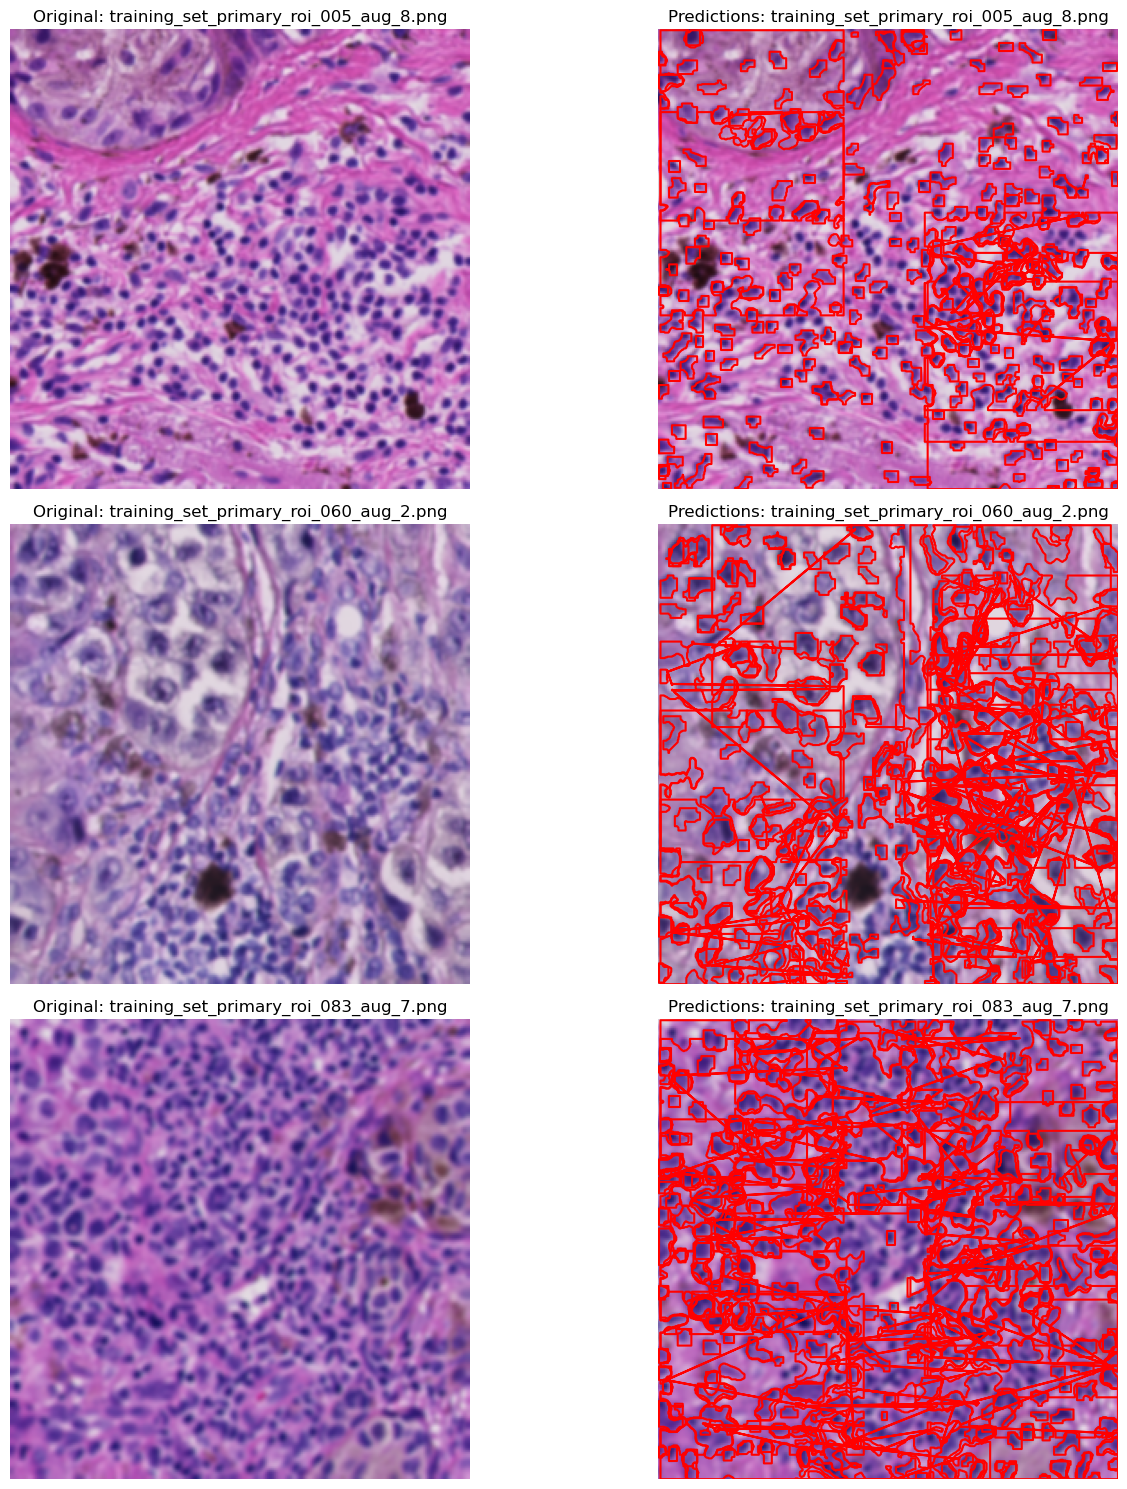

In [47]:
visualize_predictions("yolo_dataset", "melanoma_segmentation/yolo8n_model_cpu_optimized/weights/best.pt")

In [43]:
results.results_dict

{'metrics/precision(B)': 0.12266073459572685,
 'metrics/recall(B)': 0.05903620397187395,
 'metrics/mAP50(B)': 0.0829364773852687,
 'metrics/mAP50-95(B)': 0.03780852365817841,
 'metrics/precision(M)': 0.02749770277202203,
 'metrics/recall(M)': 0.020220732871106702,
 'metrics/mAP50(M)': 0.018650205756983996,
 'metrics/mAP50-95(M)': 0.004971695808964124,
 'fitness': 0.04866086583465355}

In [44]:
def validate_yolo_model(yolo_dataset_dir, model_path, device="cpu"):
    print(f"Using device: {device} (Validation on CPU)")

    model = YOLO(model_path)

    print("Starting validation...")
    results = model.val(
        data=os.path.join(yolo_dataset_dir, "dataset.yaml"),
        imgsz=256,    
        batch=2,      
        conf=0.25,   
        iou=0.5,     
        device=device,
        save_json=True,  
        plots=True       
    )

    metrics = {
        "precision": results.box.map50,  
        "recall": results.box.map,       
        "f1_score": 2 * (results.box.map50 * results.box.map) / (results.box.map50 + results.box.map + 1e-6),
        "mAP50": results.box.map50,     
        "mAP50-95": results.box.map     
    }

    print(f"\nValidation Metrics: {metrics}")
    return results, metrics

In [ ]:
results, metrics = validate_yolo_model("yolo_dataset", "melanoma_segmentation/yolo8n_model_cpu_optimized/weights/best.pt")

Using device: cpu (Validation on CPU)
Starting validation...
Ultralytics 8.3.95 🚀 Python-3.12.3 torch-2.5.1+cu124 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
YOLOv8n-seg summary (fused): 85 layers, 3,262,744 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /home/tamim-ishrak/Documents/malenoma/yolo_dataset/labels/val.cache... 820 images, 0 backgrounds, 0 corrupt: 100%|██████████| 820/820 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/410 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 1/410 [00:00<03:45,  1.82it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 2/410 [00:01<04:36,  1.48it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  95%|█████████▌| 391/410 [02:30<00:09,  2.05it/s]

# 5 Fold Cross Vzalidation

In [1]:
def cross_validate_yolo(yolo_dataset_dir, device="cpu", folds=5):
    """Perform k-fold cross-validation for YOLO segmentation."""
    
    image_dir = os.path.join(yolo_dataset_dir, "images", "train")
    label_dir = os.path.join(yolo_dataset_dir, "labels", "train")
    
    # Get all image & label files
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])
    
    # Ensure images and labels match
    assert len(image_files) == len(label_files), "Mismatch between images and labels!"
    
    num_samples = len(image_files)
    
    # Ensure `n_splits` is valid
    if folds > num_samples:
        print(f"Reducing `n_splits` from {folds} to {num_samples} (not enough samples).")
        folds = num_samples

    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(image_files)):
        print(f"\n=== Cross-Validation Fold {fold+1}/{folds} ===")
        
        # Create fold directories
        fold_dir = os.path.join(yolo_dataset_dir, f"fold_{fold}")
        train_image_dir = os.path.join(fold_dir, "images", "train")
        val_image_dir = os.path.join(fold_dir, "images", "val")
        train_label_dir = os.path.join(fold_dir, "labels", "train")
        val_label_dir = os.path.join(fold_dir, "labels", "val")

        os.makedirs(train_image_dir, exist_ok=True)
        os.makedirs(val_image_dir, exist_ok=True)
        os.makedirs(train_label_dir, exist_ok=True)
        os.makedirs(val_label_dir, exist_ok=True)

        # Copy images & labels to respective folds
        for idx in train_idx:
            shutil.copy(os.path.join(image_dir, image_files[idx]), train_image_dir)
            shutil.copy(os.path.join(label_dir, label_files[idx]), train_label_dir)

        for idx in val_idx:
            shutil.copy(os.path.join(image_dir, image_files[idx]), val_image_dir)
            shutil.copy(os.path.join(label_dir, label_files[idx]), val_label_dir)

        # Create `dataset.yaml` for this fold
        yaml_path = os.path.join(yolo_dataset_dir, "dataset.yaml")
        with open(yaml_path, 'r') as f:
            original_yaml = yaml.safe_load(f)

        fold_yaml = {
            'path': os.path.abspath(fold_dir),
            'train': 'images/train',
            'val': 'images/val',
            'names': original_yaml['names'],
            'nc': original_yaml['nc']
        }

        with open(os.path.join(fold_dir, "dataset.yaml"), 'w') as f:
            yaml.dump(fold_yaml, f)

        # Train and validate on this fold
        results = train_yolo_model(fold_dir, device)
        model_path = f"melanoma_segmentation/yolov8_fold_{fold}_weights/best.pt"
        fold_metrics = validate_yolo_model(fold_dir, model_path, device)

        # Store results
        fold_results.append({'fold': fold, 'metrics': fold_metrics[1], 'model_path': model_path})

        # Save a copy of this fold's best model
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        shutil.copy(f"melanoma_segmentation/yolov8_model_v2/weights/best.pt", model_path)

    # Convert results to DataFrame
    metrics_df = pd.DataFrame([f['metrics'] for f in fold_results])
    metrics_df['fold'] = range(folds)

    # Compute mean & std across folds
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print("\nCross-Validation Results:")
    print(metrics_df)
    print("\nMean Metrics Across Folds:")
    print(mean_metrics)
    print("\nStandard Deviation Across Folds:")
    print(std_metrics)

    # Best fold selection
    best_fold_idx = metrics_df['mAP50'].idxmax()
    best_fold = fold_results[best_fold_idx]

    print(f"\nBest Fold: {best_fold_idx} with mAP50: {best_fold['metrics']['mAP50']:.4f}")
    print(f"Best Model Path: {best_fold['model_path']}")

    return fold_results, best_fold

In [ ]:
cross_validate_yolo("yolo_dataset")